In [3]:
# Importing needed libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# NLTK tools for text processing
import re, nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS


# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [5]:
import spacy.cli
spacy.cli.download("pt_core_news_sm")

⚠ Skipping model package dependencies and setting `--no-deps`. You
don't seem to have the spaCy package itself installed (maybe because you've
built from source?), so installing the model dependencies would cause spaCy to
be downloaded, which probably isn't what you want. If the model package has
other dependencies, you'll have to install them manually.
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [6]:
import pt_core_news_sm

spc_pt = pt_core_news_sm.load()

In [7]:
data= pd.read_csv('archive/olist_order_reviews_dataset.csv')
data.head(2)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13


In [8]:
data.drop(['order_id', 'review_creation_date', 'review_answer_timestamp'],
          1, inplace = True)

In [9]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   review_id               100000 non-null  object
 1   review_score            100000 non-null  int64 
 2   review_comment_title    11715 non-null   object
 3   review_comment_message  41753 non-null   object
dtypes: int64(1), object(3)
memory usage: 3.1+ MB


In [10]:
duplicate=round(sum(data.duplicated("review_id"))/len(data)*100, 2)
print( 'Duplicate values in percentage',duplicate,'%')

Duplicate values in percentage 0.83 %


In [11]:
data[data.duplicated("review_id", keep =  False)].sort_values(by = "review_id")

,review_id,review_score,review_comment_title,review_comment_message
47045,00130cbe1f9d422698c812ed8ded1919,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid..."
30062,00130cbe1f9d422698c812ed8ded1919,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid..."
63695,0115633a9c298b6a98bcbe4eee75345f,5,NaN,NaN
91399,0115633a9c298b6a98bcbe4eee75345f,5,NaN,NaN
57727,0174caf0ee5964646040cd94e15ac95e,1,NaN,Produto entregue dentro de embalagem do fornec...
...,...,...,...,...
40677,fe5c833752953fed3209646f1f63b53c,1,NaN,"Comprei dois produtos e ambos, mesmo enviados ..."
7924,ff2fc9e68f8aabfbe18d710b83aabd30,2,NaN,NaN
83183,ff2fc9e68f8aabfbe18d710b83aabd30,2,NaN,NaN
1997,ffb8cff872a625632ac983eb1f88843c,3,NaN,NaN


In [12]:
data.drop_duplicates("review_id", inplace = True) #Removed duplicate

In [13]:
data.fillna('', inplace = True)

In [14]:
#combine coment title and message
data['review'] = data['review_comment_title'] + ' ' + data['review_comment_message']

In [15]:
data = data[data['review'] != ' ']

In [16]:
data.head(10)

,review_id,review_score,review_comment_title,review_comment_message,review
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok..."
16,9314d6f9799f5bfba510cc7bcd468c01,2,,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...","GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI ..."
19,373cbeecea8286a2b66c97b1b157ec46,1,Não chegou meu produto,Péssimo,Não chegou meu produto Péssimo
22,d21bbc789670eab777d27372ab9094cc,5,Ótimo,Loja nota 10,Ótimo Loja nota 10
24,0e0190b9db53b689b285d3f3916f8441,5,,obrigado pela atençao amim dispensada,obrigado pela atençao amim dispensada
27,fe3db7c069d694bab50cc43463f91608,5,,A compra foi realizada facilmente.\r\nA entreg...,A compra foi realizada facilmente.\r\nA entre...


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43152 entries, 3 to 99999
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               43152 non-null  object
 1   review_score            43152 non-null  int64 
 2   review_comment_title    43152 non-null  object
 3   review_comment_message  43152 non-null  object
 4   review                  43152 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.0+ MB


In [18]:
# review score
data['review_score'].value_counts()

5    21762
1     9153
4     6296
3     3721
2     2220
Name: review_score, dtype: int64

In [19]:
labels = []

for score in data['review_score']:
  if score > 3:
    labels.append(1)
  else:
    labels.append(0)

data['label'] = labels


In [20]:
data.head(5)

,review_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,1
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...,1
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...,1
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n",1
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok...",1


<Figure size 576x432 with 0 Axes>

/Users/mohannollu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

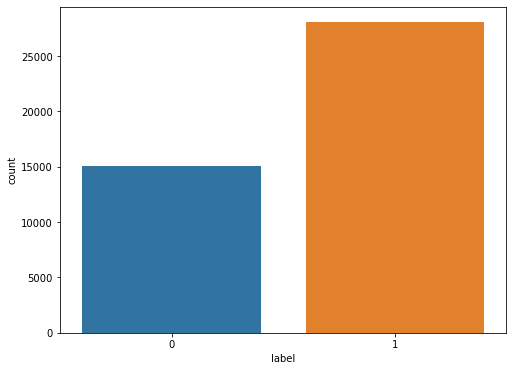

In [21]:
plt.figure(figsize=(8,6))
sns.countplot(data['label'])
plt.show()


In [22]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohannollu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
stopwords_pt = stopwords.words("portuguese")


In [25]:
stopwords_pt.remove('não')
stopwords_pt.remove('nem')

In [26]:
def simple_text(text):

  text = text.lower()

  text = re.sub(r"[\W\d_]+", " ", text)

  text = [t for t in text.split() if t not in stopwords_pt]

  specific_text = spc_pt(" ".join(text))
  tokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in specific_text]
  
  return " ".join(tokens)

In [27]:
data['review'] = data['review'].apply(simple_text)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43152 entries, 3 to 99999
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               43152 non-null  object
 1   review_score            43152 non-null  int64 
 2   review_comment_title    43152 non-null  object
 3   review_comment_message  43152 non-null  object
 4   review                  43152 non-null  object
 5   label                   43152 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.3+ MB


In [29]:

data.head(10)

,review_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,receber bem antar prazo estipular,1
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,parabém loja lannister adorar comprar internet...,1
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendar aparelhar eficiente site marcar apa...,1
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",pouco travar valor ta bom,1
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",super recomendar vendedor confiável produto ok...,1
16,9314d6f9799f5bfba510cc7bcd468c01,2,,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",gostar saber sempre receber comprar agora decp...,0
19,373cbeecea8286a2b66c97b1b157ec46,1,Não chegou meu produto,Péssimo,não chegar produto mau,0
22,d21bbc789670eab777d27372ab9094cc,5,Ótimo,Loja nota 10,ótimo loja noto,1
24,0e0190b9db53b689b285d3f3916f8441,5,,obrigado pela atençao amim dispensada,obrigar atençao amim dispensar,1
27,fe3db7c069d694bab50cc43463f91608,5,,A compra foi realizada facilmente.\r\nA entreg...,comprar realizar facilmente entregar efetuada ...,1


In [30]:
data.to_csv('olist_preprocessado.csv', index= False, columns= ['review_id', 'review', 'label'])

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

In [32]:
vectorizer = CountVectorizer(binary=True, max_features=5000)

text = data['review']
X_bow = vectorizer.fit_transform(text)

In [33]:
X_bow.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [34]:

print(X_bow.shape, type(X_bow))

(43152, 5000) <class 'scipy.sparse.csr.csr_matrix'>


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
tfidf_vect = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vect.fit_transform(text)

In [37]:
print(X_tfidf)


  (0, 1883)	0.6929845750066604
  (0, 3677)	0.30582204275116415
  (0, 269)	0.3529748289184372
  (0, 578)	0.427882135533294
  (0, 3994)	0.34434126272030036
  (1, 3873)	0.47846657405507714
  (1, 2060)	0.30329552333345583
  (1, 4625)	0.2122474442238849
  (1, 3846)	0.32356855001772633
  (1, 4325)	0.3310383748193441
  (1, 2564)	0.3119241979143323
  (1, 1018)	0.12848597336592513
  (1, 85)	0.21633389797703662
  (1, 2675)	0.20446904414639935
  (1, 2783)	0.16840400503886988
  (1, 3391)	0.4347141225647072
  (2, 4850)	0.1814508898432659
  (2, 1179)	0.1652280619841952
  (2, 444)	0.29561525042009507
  (2, 3185)	0.23428872872129516
  (2, 3348)	0.14552128500528355
  (2, 877)	0.095095271004217
  (2, 2445)	0.29561525042009507
  (2, 2887)	0.40088120455728765
  (2, 4404)	0.14898195501604616
  :	:
  (43150, 3748)	0.29943684804148946
  (43150, 837)	0.30781141837200193
  (43150, 795)	0.20544408896673358
  (43150, 2665)	0.46337723877546233
  (43150, 1499)	0.18814180530928598
  (43150, 3009)	0.1892771778084533

In [38]:
from sklearn.model_selection import train_test_split


In [39]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X_bow, data['label'],
                                                        test_size=0.3, random_state = 10)

X2_train, X2_test, y2_train, y2_test = train_test_split(X_tfidf, data['label'],
                                                        test_size=0.3, random_state = 10)

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score

In [52]:
def Result(y_true, y_pred):
  print("\nF1-Score:", f1_score(y_true, y_pred, average='weighted'))
  plt.show()

In [53]:
LR = LogisticRegression()
LR.fit(X1_train, y1_train)
y1_LR_pred = LR.predict(X1_test)
Result(y1_test, y1_LR_pred)

/Users/mohannollu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()


F1-Score: 0.8939809804110078


In [54]:
reglog2 = LogisticRegression()

reglog2.fit(X2_train, y2_train)

y2_reglog_pred = reglog2.predict(X2_test)

Result(y2_test, y2_reglog_pred)

LogisticRegression()


F1-Score: 0.899100325723324


In [57]:
def new_predictor(text):
  
  text_vectorize = tfidf_vect.transform([text])
  pred = reglog2.predict(text_vectorize )

  if pred == 0:
    print("review is negative.")
  else:
    print("review is positive.")

In [58]:
new_predictor("Demorou muito não gostei")

review is negative.
